In [1]:
!which python

/Users/nmmsv/miniforge3/envs/karpathy/bin/python


In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def f(x):
    return 3*x**2 -4 * x + 5

In [5]:
f(3.0)

20.0

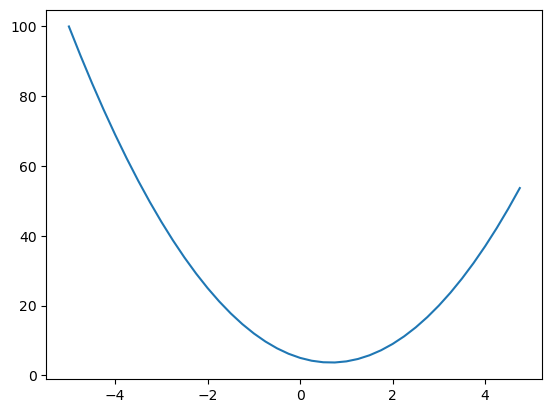

In [6]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [7]:
h = 0.0001
x = -3.0
(f(x + h) - f(x)) / h

-21.999700000066014

In [55]:
# The data structure for holding the expressions in micrograd
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _children = (self, other), _op='+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __rmul__(self, other): # other * self -> to allow 2 * a
        return self * other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _children = (self, other), _op='*')
        def _backward ():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __pow__(self, other):
        assert isinstance(other, (int, float)) #, "only supporting int/fload powers for now
        out = Value(self.data **other, (self, ), f'**{other}')
        def _backward():
            self.grad = other * self.data**(other - 1) * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def __radd__(self, other): # other + self
        return self + other    
    def exp(self):
        x = self.data
        out = Value(np.exp(x), _children = (self,), _op='exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
            
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, _children = (self,), _op='tanh')

        def _backward():
            self.grad += (1 - t ** 2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    # def __sub__(self, other):
    #     return Value(self.data - other.data, _children = (self, other), )

In [9]:
a = Value(2.0)
b = Value(4.0)
# a / b -> a * 1/b -> a * b**(-1)
a - b

Value(data=-2.0)

In [10]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [11]:
from graphviz import Digraph
def trace(root):
    # builds and sets up all the nodes and edges in the graph
    nodes, edges = set(), set()
    def build(v):
        nodes.add(v)
        for child in v._prev:
            edges.add((child, v))
            build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR: Left to right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the gragh create a record node 
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            # if this value is the result of an operation, create an op node for it
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot


In [12]:
L.grad = 1.0

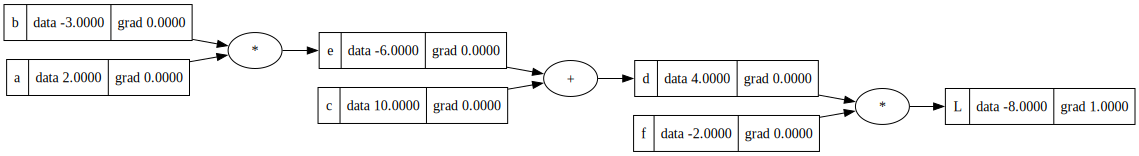

In [13]:
draw_dot(L)

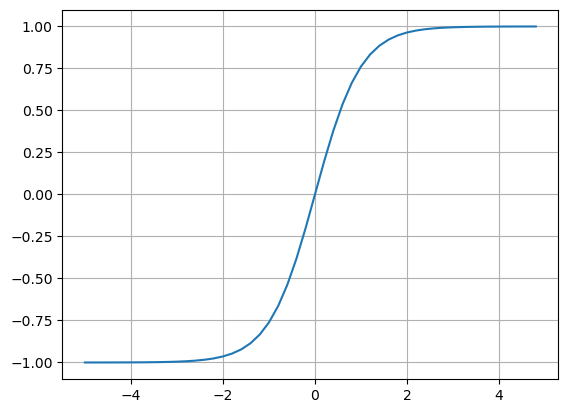

In [14]:
# Squashing or activation function
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [15]:
# neurons
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2 (synatptic strengths)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373587095432, label='b')
# cell body raw activation: n = x1w1 + x2w2 + b
# n goes throw an activation function (like tanh)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# Actual output of the neuron 
o = n.tanh(); o.label='o'


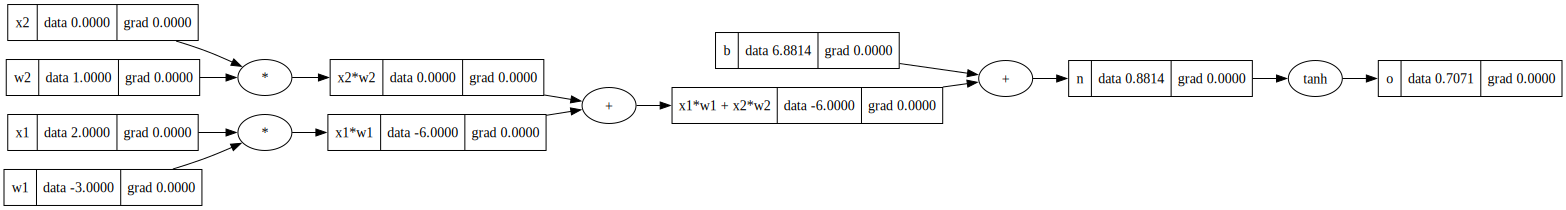

In [16]:
draw_dot(o)

In [17]:
o.backward()

In [18]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()


In [19]:
# using topological sort (a graph such that all edges are going from left to right)
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587095432),
 Value(data=0.8813735870954318),
 Value(data=0.7071067812244919)]

In [20]:
# backprob using _backward function
o.grad = 1.0
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

In [21]:
# manual backprop

In [22]:
# o = tanh(n) what is do/dn?
# do/dn = 1 - tanh(n)**2 = 1 - o**2
1 - o.data**2

0.4999999999463386

In [23]:
# now we do back prop and fill in the grads
# We mostly care about the do/dw
o.grad = 1.0
n.grad = 0.5 # (1 - o**2)
# + is just a distributor of grad
x1w1x2w2.grad = 0.5
b.grad = 0.5
# + is just a distributor of grad
x1w1.grad = 0.5
x2w2.grad = 0.5
# * node means the local deriv is the value of the other node
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

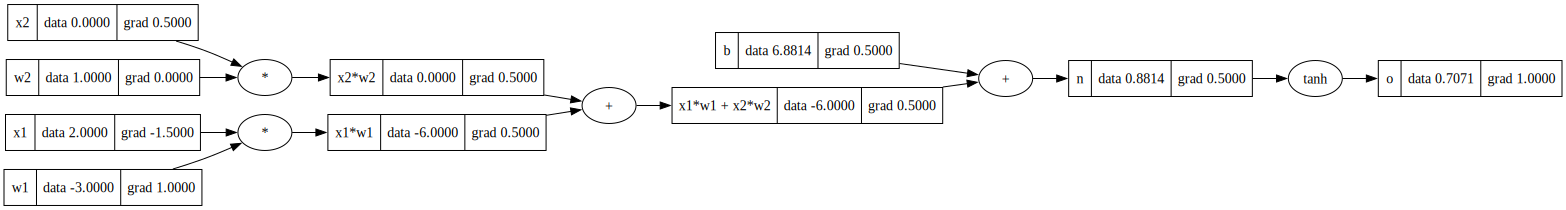

In [24]:
draw_dot(o)

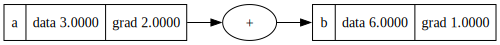

In [25]:
# bug:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

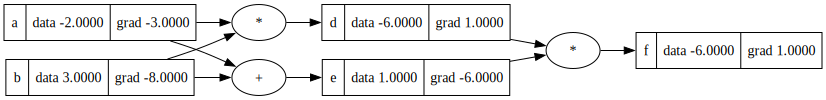

In [26]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()
draw_dot(f)

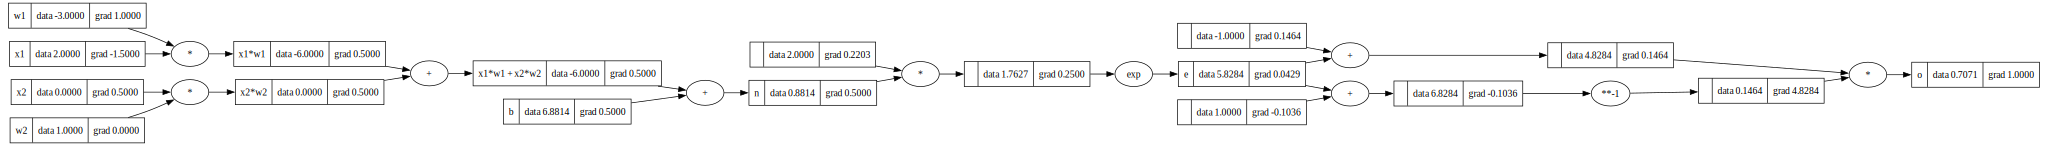

In [205]:
# now we want to use the def o tanh instead of the function tanh

# neurons
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2 (synatptic strengths)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.881373587095432, label='b')
# cell body raw activation: n = x1w1 + x2w2 + b
# n goes throw an activation function (like tanh)
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ------
e = (2 * n).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
# ------
o.label='o'
o.backward()

draw_dot(o)

In [33]:
import torch
# casting it to double precision (by default it's only fload32, in python default is float64)

x1 = torch.Tensor([2.0]).double()               ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()               ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()              ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()               ; w2.requires_grad = True
b = torch.Tensor([6.881373587095432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('w2', w2.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('x1', x1.grad.item())

0.7071066904050358
---
w2 0.0
x2 0.5000001283844369
w1 1.0000002567688737
x1 -1.5000003851533106


In [34]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [102]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((xi*wi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    


In [196]:
x = [2.0, 3.0, -1]
n = MLP(3, [4, 4, 1])
n(x)
len(n.parameters())

41

In [197]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired target

In [204]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    # sum squared error
    loss = sum([(yout - ygt)**2 for ygt,yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.01 * p.grad

    print(k, loss.data)

0 0.003292718103813286
1 0.0032895059678249043
2 0.0032862999147094058
3 0.0032830999274352088
4 0.003279905989033736
5 0.0032767180825991754
6 0.003273536191288122
7 0.003270360298319289
8 0.00326719038697331
9 0.003264026440592371
10 0.0032608684425799515
11 0.003257716376400578
12 0.003254570225579522
13 0.0032514299737024972
14 0.0032482956044153997
15 0.0032451671014240855
16 0.003242044448494009
17 0.003238927629449985
18 0.003235816628175995
19 0.003232711428614781


In [194]:
ypred

[Value(data=0.9999999819186336),
 Value(data=-0.999997979388187),
 Value(data=-0.9999786908179614),
 Value(data=0.9999999883121351)]